In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

class Colors: 
    BLACK = '\033[30m' 
    RED = '\033[31m' 
    GREEN = '\033[32m' 
    YELLOW = '\033[33m' 
    BLUE = '\033[34m' 
    MAGENTA = '\033[35m' 
    CYAN = '\033[36m' 
    WHITE = '\033[37m' 
    UNDERLINE = '\033[4m' 
    RESET = '\033[0m'
np.set_printoptions(precision=2)

In [2]:
class Mafia_game: #class를 지정해서 mafia_game의 틀을 만듬. 
    #어째서 class를 썼냐? 하면, 이유는 없습니다.. 아직까지 잘 아는 언어가 c++이라 친숙해서 썼습니다..
    dying_rate = [] # 투표율 (상대적인 값입니다.)
    civ = 1 # 시민의 수 (default : 1)
    maf = 0 # 마피아 수 (default : 0)
    alive_civ = 0 # 살아있는 시민 수
    alive_maf = 0 # 살아있는 마피아 수
    police = None # 경찰 지정시 경찰에 대한 설정입니다. (defalut : None)
    # dictionary 형태이며,
    # ["number"]는 시민들 중 경찰의 넘버(처음에 랜덤 지정).
    # ["detect_rate"]는 마피아 검거시 투표율 배수입니다.(ex, 2이면 시민보다 2배로 잘 뽑힙니다.) (default : 1.3)
    # ["remember"]는 경찰의 기억력이 좋은가 나쁜가 입니다.(True면 기억함, False면 잊어버림) (default : False)
    # ["detect"]는 경찰이 나머지 사람들 중 탐색 확률 이며, 기억력이 좋으면 탐색확률이 0이 되어 재탐색을 하지 않습니다.
    # ["weight"]는 기억력때문에 추가한 가중치 배열로, 나머지 사람들에 대하여 1의 값을 갖다가 검거 성공시 배율의 값으로 변경.
    #           이를 투표율에 곱해서 마피아에 대한 투표율을 높입니다. 기억이 나쁘면 다시 1로 되돌아 갑니다.
    medic = None #메딕 지정 시 시민들 중 메딕의 넘버(처음에 랜덤 지정).
    msg = False #메시지를 출력할지 안할지 입니다.(default : False) - debug용이었습니다.
                # 메시지 출력 옵션을 선택하면, 시뮬 반복이 1이면, 밤/낮 별로 누가 죽는지 볼 수 있습니다.
                # 반면, 시뮬 반복이 1 초과면, 각 시뮬마다 누가 이겼는지 출력합니다.
    def __init__(self, civ=None, maf=None, police = None, medic = None): #초기화 함수 입니다.
        # 초기에 클래스 선언할 때, 초기값을 위해서도 쓰이지만
        # 주 목적은 simulation 함수를 통해 여러가지 혹은 반복되는 시뮬레이션을 할 때, 값의 변경 및 초기화를 위함입니다.
        if(civ): 
            self.civ = civ
            self.alive_civ = self.civ
        if(maf): 
            self.maf = maf
            self.alive_maf = self.maf
        self.dying_rate = np.full(self.civ+self.maf,1/(self.civ+self.maf), dtype=float)
        if(police): 
            self.police = police
            self.police["number"] = np.random.randint(civ)
            if self.police["detect_rate"] is None : self.police["detect_rate"] = 1.3
            self.police["detect"] = np.array(self.dying_rate)
            self.police["detect"][self.police["number"]] = 0.0
            self.police["weight"] = np.ones(self.maf)
            #if (not self.police["remember"]): self.backup = self.dying_rate
        if(medic is not None):
            if(police): 
                while(True):
                    self.medic = np.random.randint(civ)
                    if(self.medic != self.police["number"]): break
            else:
                self.medic = np.random.randint(civ)
                
    
    def dying_msg(self, dead, innocent): # msg 옵션 시 시뮬 과정을 셀에 출력합니다.
        if(innocent):
            if(self.police and self.police["number"] == dead):
                print(Colors.CYAN +"{0}번 경찰이 사망했습니다. (살아남은 시민수 : {1})".
                      format(dead,self.alive_civ)+Colors.RESET)
            elif(self.medic is not None) and (self.medic == dead):
                print(Colors.CYAN + "{0}번 의사가 사망했습니다. (살아남은 시민수 : {1})".
                      format(dead,self.alive_civ)+Colors.RESET)
            else: 
                print("{0}번 시민이 사망했습니다. (살아남은 시민수 : {1})".format(dead,self.alive_civ))
        else:
            print(Colors.RED+
                  "{0}번 마피아가 사망했습니다. (남은 마피아수 : {1})"
                  .format(dead-self.civ,self.alive_maf) + Colors.RESET)
        
        
    def morning(self): # 시뮬레이션에서 아침에 누굴 투표하여 죽일지 결정합니다.
        wgt = np.array(self.dying_rate)
        if(self.police): wgt[self.civ:] *= self.police["weight"] # 경찰 설정시 투표율에 검거 가중치를 곱합니다.
        #print(wgt)
        dead = np.random.choice(range(self.civ+ self.maf),p=wgt/wgt.sum()) #넘파이 가중치 랜덤 함수 이용
        self.dying_rate[dead] = 0.0 # 투표된 사람은 사망합니다.
        #if(self.police and not self.police["remember"]): self.police["detect"][dead] = 0.0
        if(self.police): 
            self.police["detect"][dead] = 0.0
        if(dead < self.civ):
            self.alive_civ -= 1
            if(self.msg): self.dying_msg(dead, True)
            if(self.alive_civ < 1): return True # 살아남은 시민이 없으면 게임 끝. True를 출력(simulation에 알려주기 위함)
        else:
            self.alive_maf -= 1
            if(self.msg): self.dying_msg(dead, False)
            if(self.alive_maf < 1): return True # 살아남은 마피아가 없으면 게임 끝. True를 출력
        return False
    
    def night(self): # 시뮬레이션에서 밤에 마피아가 누굴 죽이고, 경찰이 누굴 탐색하고, 의사가 누굴 살릴지 정합니다.
        dead = np.random.choice(range(self.civ),p=self.dying_rate[:self.civ]/self.dying_rate[:self.civ].sum())
        # 살아남은 시민들 중 죽일 사람을 정합니다.
        heal = None
        #print(self.dying_rate)
        if(self.medic is not None): # 메딕 지정시
            if(self.dying_rate[self.medic] != 0):
                heal = np.random.choice(range(self.civ+ self.maf),p=self.dying_rate/self.dying_rate.sum())
                # 전체 살아남은 사람 중 살릴 사람을 정합니다.
        
        if(dead == heal):
            if(self.msg): print(Colors.GREEN+"<의사가 희생자 치료에 성공했습니다.>"+Colors.RESET)
            #return False
        else:
            self.dying_rate[dead] = 0.0
            self.alive_civ -= 1
            if(self.police): self.police["detect"][dead] = 0.0
            #if(self.police and not self.police["remember"]): self.police["detect"][dead] = 0.0
            if(self.msg): self.dying_msg(dead, True)
            if(self.alive_civ < 2): return True # 살아남은 시민이 마피아보다 적어 게임이 끝납니다.
        
        if(self.police): # 경찰 지정시
            pol_num = self.police["number"]
            if(self.dying_rate[pol_num] != 0): # 경찰이 살아있을 경우
                search = pol_num
                if(self.police["detect"].sum() != 0): search = np.random.choice(range(self.civ+ self.maf),
                                          p=self.police["detect"]/self.police["detect"].sum())# 탐색할 사람 선택
                if(self.police["remember"]): self.police["detect"][search] = 0.0 # 기억이 좋으면 그 사람을 더이상 탐색 X
                if(search >= self.civ): # 만일 탐색한 사람이 마피아일 경우
                    if(self.msg): print(Colors.GREEN+"<경찰이 마피아 검거에 성공했습니다.>"+Colors.RESET)
                    self.police["weight"][search-self.civ] *= self.police["detect_rate"] # 투표율을 높입니다.
        return False
    
    def simulation(self, civ=None, maf=None,police = None, medic = None, msg = False, repeat = 1):
        score = {"mafia":0, "civilization":0}
        if(repeat > 1): self.msg = False
        else : self.msg = msg
        for i in range(repeat): # 같은 조건에서 시뮬을 반복하여 승률을 계산합니다.
            day = 1
            self.__init__(civ, maf, police, medic)
            while(self.alive_civ > self.alive_maf): # 시민이 마피아보다 적으면 패배입니다.
                if(self.msg): 
                    print(Colors.BLUE+"{}일 째....".format(day)+Colors.RESET)
                if(self.morning()): break
                if(self.police and not self.police["remember"]): self.police["weight"] = np.ones(self.maf)
                if(self.night()): break
                day += 1
            if(self.alive_maf < self.alive_civ): 
                if(msg): print(" - 시민의 승리입니다. - ")
                score["civilization"] += 1
            else : 
                if(msg): print(Colors.RED+" - 마피아의 승리입니다. -"+Colors.RESET)
                score["mafia"] += 1
        return score["civilization"]/repeat #반복된 횟수에서 시민의 승률을 리턴합니다.

In [3]:
police = {
    "detect_rate":12,
    "remember" : True,
    "number": -1
    
}
sim1 = Mafia_game()
sim1.simulation(10,3, msg = True, repeat = 1, police = police, medic = True)

1일 째....
5번 시민이 사망했습니다. (살아남은 시민수 : 9)
6번 시민이 사망했습니다. (살아남은 시민수 : 8)
2일 째....
2번 경찰이 사망했습니다. (살아남은 시민수 : 7)
4번 시민이 사망했습니다. (살아남은 시민수 : 6)
3일 째....
7번 시민이 사망했습니다. (살아남은 시민수 : 5)
8번 시민이 사망했습니다. (살아남은 시민수 : 4)
4일 째....
0번 의사가 사망했습니다. (살아남은 시민수 : 3)
1번 시민이 사망했습니다. (살아남은 시민수 : 2)
 - 마피아의 승리입니다. -


0.0

________________________________________________________________

## 이 아래부터는 실험하는데 저의 편리를 위해 만든 코드입니다.;;

###### 시험 내용과는 상관이 없는 부분이 많습니다. (죄송합니다.)
###### 아래 아래의 simulator() 함수를 사용하기 위함입니다.

________________________________________________________________

In [15]:
from IPython.display import clear_output


def simulator():
    data = []
    civ = None
    maf = None
    police = None
    medic = None
    while True:
        clear_output(wait=True)
        start = input("시작하시겠습니까? (y / n) ")
        if(start.lower() == 'y'):
            label = []
            while(True):
                civ = list(map(int, input("시민의 수를 입력주세요.(min ~ max) : ").split('~')))
                if(civ[0] <= civ[-1]): break
                elif(civ[0] < 1): print("잘못된 입력입니다. 다시 입력해주세요")
                else : print("잘못된 입력입니다. 다시 입력해주세요")
            while(True):
                maf = list(map(int, input("마피아 수를 입력주세요.(min ~ max) : ").split('~')))
                if(maf[0] <= maf[-1]): break
                elif(maf[0] < 1): print("잘못된 입력입니다. 다시 입력해주세요")
                else : print("잘못된 입력입니다. 다시 입력해주세요")
            while(True):
                pol = input("경찰을 설정하시겠습니까? (y / n) ")
                if(pol.lower() == 'y'):
                    police = {'number':-1}
                    rem = input("경찰의 장기 기억 설정 (y / n) ")
                    if(rem.lower() == 'y'): police["remember"] = True
                    else: police["remember"] = False
                    
                    det = float(input("조사 성공 시 투표확률 배율() : "))
                    police["detect_rate"] = abs(det)
                    break
                elif (pol.lower() == 'n'): break
                elif (pol.lower() == 'q'): return
                else: print("잘못된 입력입니다. 다시 입력해주세요")
            
            while(True):
                med = input("의사를 설정하시겠습니까? (y / n) ")
                if(med.lower() == 'y'):
                    medic = True
                    break
                elif(med.lower() == 'n'): break
                elif(med.lower() == 'q'): return
                else: print("잘못된 입력입니다. 다시 입력해주세요")
            rep = 1
            while(True):
                rep = int(input("실험을 반복할 횟수를 입력해주세요. :"))
                if(rep < 1): print("잘못된 입력입니다. 다시 입력해주세요")
                else : break
            
            msg = input("게임 메시지 출력 여부 (y / n) ")
            if(msg.lower() == 'y'):
                print("반복 횟수가 1이면 게임의 전체 과정이 출력됩니다.")
                print("이외의 경우는 게임의 승패만이 출력됩니다.")
                msg = True
            elif(msg.lower() == 'q'): return
            else: msg = False
            grp = True
            while(True):
                std = input("그래프 출력 기준 (시민, 마피아) : ")
                if(std == "시민" or std.lower() == 'citizen' or std.lower() == 'bystander'): 
                    grp = True
                    break
                elif(std == '마피아' or std.lower() == 'mafia'): 
                    grp = False
                    break
                elif(std.lower() == 'q'): return
                else: print("잘못된 입력입니다. 다시 입력해주세요.")
            _simual = Mafia_game()
            data = np.zeros((maf[-1]-maf[0]+1,civ[-1]-civ[0]+1))
            for i in range(civ[0],civ[-1]+1):
                label.append(i)
                for j in range(maf[0], maf[-1]+1):
                    if(msg): print(Colors.MAGENTA+"[  시민 수 : {0} 마피아 수 : {1}  ]".format(i,j)+Colors.RESET)
                    data[j-maf[0]][i-civ[0]]=_simual.simulation(civ = i, maf = j, msg = msg, police = police, medic = medic, repeat = rep)
            if grp:
                for i in range(maf[0], maf[-1]+1):
                    plt.plot(label, data[i-maf[0]], label = '{} mafias'.format(i))
                plt.xlabel('number of citizens')
                plt.ylabel('winning rate')
            else:
                for i in range(civ[0], civ[-1]+1):
                    plt.plot(range(maf[0], maf[-1]+1), data[:,i-civ[0]], label = '{} citizens'.format(i))
                    plt.xlabel('number of mafias')
                    plt.ylabel('winning rate')
            plt.ylim([0,1])
            plt.legend()
            plt.show()
            plt.close()
            #print(data)

        elif(start.lower() == 'n'): break
        else: print("잘못된 입력입니다. 다시 입력해주세요")
            


## 시뮬레이터 
**시작하시겠습니까?**```y: 시뮬레이터 시작 , n : 시뮬레이터 종료```
<br>**시민의 수를 입력주세요.**```ex)3 ~ 6 : 3명에서 6명까지,    4 : 4명만.    (int)```
<br>**마피아 수를 입력주세요.**```ex) 3 ~ 6 : 3명에서 6명까지,    4 : 4명만.   (int)```
<br>**경찰을 설정하시겠습니까?**```y : 경찰 설정, n : 경찰 없음, q: 시뮬레이터 종료```
    <br>　　　　　**경찰의 장기 기억 설정**``` y: 경찰의 기억력이 좋음, n: 경찰의 기억력이 나쁨 / default : 기억력 나쁨```
    <br>　　　　　**조사 성공 시 투표확률 배율**```ex) 1.5 : 마피아 검거 시 다음 아침 투표될 확률 시민보다 1.5배     (float).```
<br>**의사를 설정하시겠습니까?**```y: 의사 설정, n: 의사 없음, q: 시뮬레이터 종료```
<br>**실험을 반복할 회수를 입력해주세요.**``` ex) 100 : 같은 조건의 시뮬레이션을 100번 반복하여 (승리 횟수)/100으로 승률 계산    (int)```
<br>**게임 메시지 출력 여부**``` y:시뮬레이션 과정을 출력, n:시뮬레이션 과정 출력 안함. / default : 출력 안함```
<br>**그래프 출력 기준**```시민/citizen/bystander: 그래프 x축이 시민의 수 , 마피아/mafia: 그래프 x축이 마피아 수```

In [17]:
simulator()

시작하시겠습니까? (y / n) n


## 이 아래는 simulator()를 통해 나온 그래프를 통해 tan 실험을 위해 만든 코드입니다.

[0.1798977015579339]


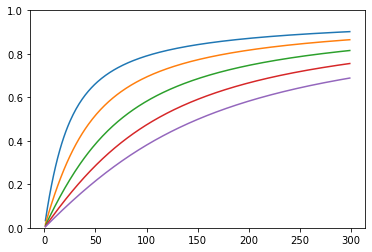

In [18]:
import numpy as np
from matplotlib import pyplot as plt

def lol(label, num):
    data = []
    for i in label:
        data.append((np.arctan((i*0.6)/(2*num**2+i**0.5
                                           +num+1/(num)))*2/np.pi))
    return data
la = range(1, 300)
dd = lol(la, 2)
d2 = lol(la, 3)
d3 = lol(la, 4)
d4 = lol(la, 5)
d5 = lol(la, 6)
plt.plot(la,dd)
plt.plot(la,d2)
plt.plot(la,d3)
plt.plot(la,d4)
plt.plot(la,d5)
plt.ylim([0,1.0])
print(lol([12], 3))